In [ ]:
pip install pyarrow

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

#pip.main(['install'] + ['pyarrow'])
#import pyarrow.parquet as pq


#yearly = '/Users/athenaye/Desktop/by_year/2001.csv.gz'
ex = './Historical Data/%s.csv'
path = ex % 'LCM'
!wc -1 $psth

wc: illegal option -- 1
usage: wc [-clmw] [file ...]


## Background

In [ ]:
twenty_sixteen_sample = pd.read_csv("/Users/athenaye/Desktop/by_year/2016.csv", header = None, names = ['station', 'date', 'data', 'value', 'mflag', 'qflag', 'sflag', 'time'], usecols=[0,1,2,3])
twenty_seventeen_sample = pd.read_csv("/Users/athenaye/Desktop/by_year/2017.csv", header = None, names = ['station', 'date', 'data', 'value', 'mflag', 'qflag', 'sflag', 'time'], usecols=[0,1,2,3])
twenty_eighteen_sample = pd.read_csv("/Users/athenaye/Desktop/by_year/2018.csv", header = None, names = ['station', 'date', 'data', 'value', 'mflag', 'qflag', 'sflag', 'time'], usecols=[0,1,2,3])
twenty_nineteen_sample = pd.read_csv("/Users/athenaye/Desktop/by_year/2019.csv", header = None, names = ['station', 'date', 'data', 'value', 'mflag', 'qflag', 'sflag', 'time'], usecols=[0,1,2,3])
twenty_twenty_sample = pd.read_csv("/Users/athenaye/Desktop/by_year/2020.csv", header = None, names = ['station', 'date', 'data', 'value', 'mflag', 'qflag', 'sflag', 'time'], usecols=[0,1,2,3])

In [ ]:
twenty_sixteen_sample['date'] = pd.to_datetime(twenty_sixteen_sample['date'], format='%Y%m%d')
twenty_seventeen_sample['date'] = pd.to_datetime(twenty_seventeen_sample['date'], format='%Y%m%d')
twenty_eighteen_sample['date'] = pd.to_datetime(twenty_eighteen_sample['date'], format='%Y%m%d')
twenty_nineteen_sample['date'] = pd.to_datetime(twenty_nineteen_sample['date'], format='%Y%m%d')
twenty_twenty_sample['date'] = pd.to_datetime(twenty_twenty_sample['date'], format='%Y%m%d')

In [ ]:
twenty_sixteen = twenty_sixteen_sample.pivot(index = ["date", "station"], columns = "data", values = "value")
twenty_seventeen = twenty_seventeen_sample.pivot(index = ["date", "station"], columns = "data", values = "value")
twenty_eighteen = twenty_eighteen_sample.pivot(index = ["date", "station"], columns = "data", values = "value")
twenty_nineteen = twenty_nineteen_sample.pivot(index = ["date", "station"], columns = "data", values = "value")
twenty_twenty = twenty_twenty_sample.pivot(index = ["date", "station"], columns = "data", values = "value")

In [ ]:
twenty_sixteen.to_parquet("/Users/athenaye/Desktop/by_year/2016.parquet")

In [ ]:
twenty_seventeen.to_parquet("/Users/athenaye/Desktop/by_year/2017.parquet")
twenty_eighteen.to_parquet("/Users/athenaye/Desktop/by_year/2018.parquet")
twenty_nineteen.to_parquet("/Users/athenaye/Desktop/by_year/2019.parquet")
twenty_twenty.to_parquet("/Users/athenaye/Desktop/by_year/2020.parquet")

## For loop to save as a parquet

In [23]:
#Globbing
for py in glob.glob("/Users/athenaye/Desktop/by_year/*.csv"):
    csv = pd.read_csv(py, header = None, names = ['station', 'date', 'data', 'value', 'mflag', 'qflag', 'sflag', 'time'], usecols=[0,1,2,3])
    csv['date'] = pd.to_datetime(csv['date'], format='%Y%m%d')
    pivot = csv.pivot(index = ["date", "station"], columns = "data", values = "value")
    pivot.to_parquet(py+".parquet")
    #pd.read_csv("/Users/athenaye/Desktop/by_year/2016.csv", header = None, names = ['station', 'date', 'data', 'value', 'mflag', 'qflag', 'sflag', 'time'], usecols=[0,1,2,3])

In [4]:
stat = pd.read_parquet("/Users/athenaye/Desktop/by_year_parquet_trial/2014.csv.parquet")
print(stat)

data                    AWDR  AWND  DAPR  DASF  DATN  DATX  DWPR  EVAP  MDPR  \
date       station                                                             
2014-01-01 AE000041196   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
           AEM00041194   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
           AEM00041217   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
           AEM00041218   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
           AFM00040938   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...                      ...   ...   ...   ...   ...   ...   ...   ...   ...   
2014-12-31 WZ004455110   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
           ZA000067743   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
           ZI000067775   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
           ZI000067975   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
           ZI000067983   NaN   NaN   NaN

## For loop to filter columns

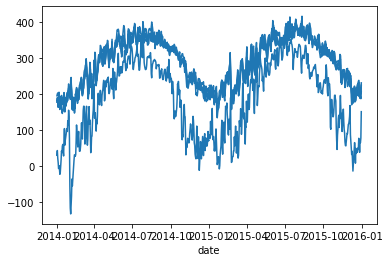

In [8]:
#def colex(columnname):
stationlist = ['AE000041196', 'AEM00041194', 'AEM00041217', 'AEM00041218', 'AFM00040938']
ultimatetavg = []
for f in glob.glob("/Users/athenaye/Desktop/by_year_parquet_trial/*.csv.parquet"):
    for s in range(len(stationlist)):
        currentparq = pd.read_parquet(f)
        currentparq = currentparq['TAVG']
        stationtavg = currentparq.xs((stationlist[s]), level = "station")
        ultimatetavg.append(stationtavg)
        sns.lineplot(data = ultimatetavg, legend = False)


In [16]:
for f in glob.glob("/Users/athenaye/Desktop/by_year_parquet_trial/*.csv.parquet"):
    read = pd.read_parquet(f)
    print(read.columns)

Index(['AWDR', 'AWND', 'DAPR', 'DASF', 'DATN', 'DATX', 'DWPR', 'EVAP', 'MDPR',
       'MDSF', 'MDTN', 'MDTX', 'MNPN', 'MXPN', 'PGTM', 'PRCP', 'PSUN', 'SN31',
       'SN32', 'SN33', 'SN35', 'SN36', 'SN51', 'SN52', 'SN53', 'SN55', 'SN56',
       'SNOW', 'SNWD', 'SX31', 'SX32', 'SX33', 'SX35', 'SX36', 'SX51', 'SX52',
       'SX53', 'SX55', 'SX56', 'TAVG', 'THIC', 'TMAX', 'TMIN', 'TOBS', 'TSUN',
       'WDF2', 'WDF5', 'WDFG', 'WDMV', 'WESD', 'WESF', 'WSF2', 'WSF5', 'WSFG',
       'WSFI', 'WT01', 'WT02', 'WT03', 'WT04', 'WT05', 'WT06', 'WT07', 'WT08',
       'WT09', 'WT10', 'WT11'],
      dtype='object', name='data')
Index(['AWDR', 'AWND', 'DAPR', 'DASF', 'DATN', 'DATX', 'DWPR', 'EVAP', 'MDPR',
       'MDSF', 'MDTN', 'MDTX', 'MNPN', 'MXPN', 'PGTM', 'PRCP', 'PSUN', 'SN31',
       'SN32', 'SN33', 'SN35', 'SN36', 'SN51', 'SN52', 'SN53', 'SN55', 'SN56',
       'SN57', 'SNOW', 'SNWD', 'SX31', 'SX32', 'SX33', 'SX35', 'SX36', 'SX51',
       'SX52', 'SX53', 'SX55', 'SX56', 'SX57', 'TAVG', 'THIC', '

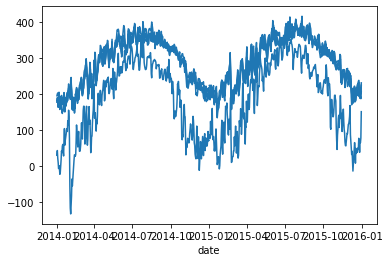

In [19]:
years = []
stationlist = ['AE000041196', 'AEM00041194', 'AEM00041217', 'AEM00041218', 'AFM00040938']
ultimatetavg = []
for f in glob.glob("/Users/athenaye/Desktop/by_year_parquet_trial/*.csv.parquet"):
    for s in range(len(stationlist)):
        read = pd.read_parquet(f)
        parameter = 'TAVG'
        if parameter in read.columns:
            years.append(f)
        else:
            print(str(parameter)+ ' was not found in ' + f)
            break
        read = read[parameter]
        stationtavg = read.xs((stationlist[s]), level = "station")
        ultimatetavg.append(stationtavg)
        sns.lineplot(data = ultimatetavg, legend = False)
    

In [27]:
def extract(parameter, stationlist):
    years = []
    ultimatetavg = []
    for f in glob.glob("/Users/athenaye/Desktop/by_year_parquet_trial/*.csv.parquet"):
        for s in range(len(stationlist)):
            read = pd.read_parquet(f)
            if parameter in read.columns:
                years.append(f)
            else:
                print(str(parameter)+ ' was not found in ' + f)
                break
            read = read[parameter]
            stationtavg = read.xs((stationlist[s]), level = "station")
            print(str(s) + "is" + stationtavg)
            ultimatetavg.append(stationtavg)
            print(s + "is" + ultimatetavg)
            sns.lineplot(data = ultimatetavg, legend = False)

In [28]:
hi = ['AE000041196', 'AEM00041194', 'AEM00041217', 'AEM00041218', 'AFM00040938']
bye = 'TAVG'

extract(bye, hi)

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> dtype('<U32')

## Start Here

In [2]:
masterlist = ['AWDR', 'AWND','DAPR', 'DASF', 'DATN', 'DATX', 'DWPR', 'EVAP', 'MDPR', 'MDSF', 'MDTN', 
 'MDTX', 'MNPN', 'MXPN', 'PGTM', 'PRCP', 'PSUN', 'SN31', 'SN32', 'SN33', 'SN35', 'SN36', 'SN51', 'SN52', 'SN53', 
 'SN55', 'SN56', 'SNOW', 'SNWD', 'SX31', 'SX32', 'SX33', 'SX35', 'SX36', 'SX51', 'SX52', 'SX53', 'SX55', 'SX56', 
 'TAVG','THIC', 'TMAX', 'TMIN', 'TOBS', 'TSUN', 'WDF2', 'WDF5', 'WDFG', 'WDMV','WESD', 'WESF', 'WSF2', 'WSF5',
 'WSFG', 'WSFI', 'WT01', 'WT02', 'WT03', 'WT04', 'WT05', 'WT06', 'WT07', 'WT08', 'WT09', 'WT10']
#sixteen_through_twenty = np.append(twenty_sixteen, (twenty_seventeen,twenty_eighteen,twenty_nineteen,twenty_twenty))

In [3]:
twenty_sixteen = pd.read_parquet("/Users/athenaye/Desktop/by_year/2016.parquet", columns= masterlist)
twenty_seventeen = pd.read_parquet("/Users/athenaye/Desktop/by_year/2017.parquet", columns= masterlist)
twenty_eighteen = pd.read_parquet("/Users/athenaye/Desktop/by_year/2018.parquet", columns= masterlist)
twenty_nineteen = pd.read_parquet("/Users/athenaye/Desktop/by_year/2019.parquet", columns= masterlist)
twenty_twenty = pd.read_parquet("/Users/athenaye/Desktop/by_year/2020.parquet", columns= masterlist)

heatmap, frequency along the x axis, row is environment variable
use fourier
across all years and all stations
concatenated time series for each station across all years, take fourier transform, do that for every station and average them togehter, important to normalize the data, separate repository for historical data project

In [22]:
yearlist= [twenty_sixteen, twenty_seventeen, twenty_eighteen, twenty_nineteen, twenty_twenty]
stationlist = ['AE000041196', 'AEM00041194', 'AEM00041217', 'AEM00041218', 'AFM00040938']
ultimatetavg = []

def extract(envivar, years, stations):
    for y in range(len(yearlist)):
        for s in range(len(stationlist)):
            tavg = yearlist[y]
            tavg = tavg['TAVG']
            stationtavg = tavg.xs((stationlist[s]), level = "station")
            print(stationtavg)
            ultimatetavg.append(stationtavg)
            print(ultimatetavg)
            sns.lineplot(data = ultimatetavg, legend = False)

NameError: name 'twenty_sixteen' is not defined

In [ ]:
hi1=twenty_sixteen["TAVG"]
hi2=twenty_seventeen["TAVG"]
hi3=twenty_eighteen["TAVG"]
hi4=twenty_nineteen["TAVG"]
hi5=twenty_twenty["TAVG"]

<AxesSubplot:xlabel='date'>

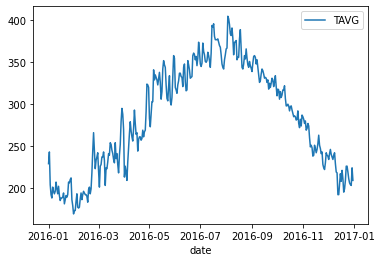

In [31]:
sns.lineplot(data = ultimatetavg)

In [ ]:
a1 = hi1.xs(("AE000041196"), level = "station")
a2 = hi2.xs(("AE000041196"), level = "station")
a3 = hi3.xs(("AE000041196"), level = "station")
a4 = hi4.xs(("AE000041196"), level = "station")
a5 = hi5.xs(("AE000041196"), level = "station")

bruh = np.concatenate((a1,a2,a3,a4,a5))

In [ ]:
b1 = hi1.xs(("AEM00041194"), level = "station")
b2 = hi2.xs(("AEM00041194"), level = "station")
b3 = hi3.xs(("AEM00041194"), level = "station")
b4 = hi4.xs(("AEM00041194"), level = "station")
b5 = hi5.xs(("AEM00041194"), level = "station")

bruh2 = np.concatenate((b1,b2,b3,b4,b5))

In [ ]:
c1 = hi1.xs(("AEM00041217"), level = "station")
c2 = hi2.xs(("AEM00041217"), level = "station")
c3 = hi3.xs(("AEM00041217"), level = "station")
c4 = hi4.xs(("AEM00041217"), level = "station")
c5 = hi5.xs(("AEM00041217"), level = "station")

bruh3 = np.concatenate((c1,c2,c3,c4,c5))

In [ ]:
d1 = hi1.xs(("AEM00041218"), level = "station")
d2 = hi2.xs(("AEM00041218"), level = "station")
d3 = hi3.xs(("AEM00041218"), level = "station")
d4 = hi4.xs(("AEM00041218"), level = "station")
d5 = hi5.xs(("AEM00041218"), level = "station")

bruh4 = np.concatenate((d1,d2,d3,d4,d5))

In [ ]:
e1 = hi1.xs(("AFM00040938"), level = "station")
e2 = hi2.xs(("AFM00040938"), level = "station")
e3 = hi3.xs(("AFM00040938"), level = "station")
e4 = hi4.xs(("AFM00040938"), level = "station")
e5 = hi5.xs(("AFM00040938"), level = "station")

bruh5 = np.concatenate((e1,e2,e3,e4,e5))

In [ ]:
sns.lineplot(data = bruh)
sns.lineplot(data = bruh2)
sns.lineplot(data = bruh3)
sns.lineplot(data = bruh4)
sns.lineplot(data = bruh5)

In [ ]:
plt.plot(bruh, alpha=0.40)
plt.plot(bruh2, alpha=0.40)
plt.plot(bruh3, alpha=0.40)
plt.plot(bruh4, alpha=0.40)
plt.plot(bruh5, alpha=0.40)

## PRCP

In [ ]:
prcp1=twenty_sixteen["PRCP"]
prcp2=twenty_seventeen["PRCP"]
prcp3=twenty_eighteen["PRCP"]
prcp4=twenty_nineteen["PRCP"]
prcp5=twenty_twenty["PRCP"]

In [ ]:
a1 = prcp1.xs(("AE000041196"), level = "station")
a2 = prcp2.xs(("AE000041196"), level = "station")
a3 = prcp3.xs(("AE000041196"), level = "station")
a4 = prcp4.xs(("AE000041196"), level = "station")
a5 = prcp5.xs(("AE000041196"), level = "station")

prcpstation1 = np.concatenate((a1,a2,a3,a4,a5))

In [ ]:
b1 = prcp1.xs(("AEM00041194"), level = "station")
b2 = prcp2.xs(("AEM00041194"), level = "station")
b3 = prcp3.xs(("AEM00041194"), level = "station")
b4 = prcp4.xs(("AEM00041194"), level = "station")
b5 = prcp5.xs(("AEM00041194"), level = "station")

prcpstation2 = np.concatenate((b1,b2,b3,b4,b5))

In [ ]:
c1 = prcp1.xs(("AEM00041217"), level = "station")
c2 = prcp2.xs(("AEM00041217"), level = "station")
c3 = prcp3.xs(("AEM00041217"), level = "station")
c4 = prcp4.xs(("AEM00041217"), level = "station")
c5 = prcp5.xs(("AEM00041217"), level = "station")

prcpstation3 = np.concatenate((c1,c2,c3,c4,c5))

In [ ]:
d1 = prcp1.xs(("AEM00041218"), level = "station")
d2 = prcp2.xs(("AEM00041218"), level = "station")
d3 = prcp3.xs(("AEM00041218"), level = "station")
d4 = prcp4.xs(("AEM00041218"), level = "station")
d5 = prcp5.xs(("AEM00041218"), level = "station")

prcpstation4 = np.concatenate((d1,d2,d3,d4,d5))

In [ ]:
e1 = prcp1.xs(("AFM00040938"), level = "station")
e2 = prcp2.xs(("AFM00040938"), level = "station")
e3 = prcp3.xs(("AFM00040938"), level = "station")
e4 = prcp4.xs(("AFM00040938"), level = "station")
e5 = prcp5.xs(("AFM00040938"), level = "station")

prcpstation5 = np.concatenate((e1,e2,e3,e4,e5))

In [ ]:
sns.lineplot(data = prcpstation1)
#sns.lineplot(data = prcpstation2)
sns.lineplot(data = prcpstation3)
sns.lineplot(data = prcpstation4)
#sns.lineplot(data = prcpstation5)

In [ ]:
twenty_sixteen["TAVG"].plot(ax ="date", kind='line')

In [ ]:
sns.lineplot(data = twenty_sixteen.iloc[: , 1:100])

In [ ]:
#pd.set_option("display.max_rows", None, "display.max_columns", None)
parquet_hugepivot = pd.read_parquet("/Users/athenaye/Downloads/trial.parquet", columns = ['TAVG'])
#parquet_hugepivot.pivot(index = "date", columns = "station", values = "TAVG")
print(parquet_hugepivot)

In [ ]:
hugepivot["TAVG"].memory_usage()

In [ ]:
hugepivot.memory_usage()

In [ ]:
hugepivot[0:5, ]

In [ ]:
twenty_nineteen_sample.to_parquet("/Users/athenaye/Downloads/improved2019.parquet")

#1 Try to make the biggest pandas data frame, load into parquet   
    then just do the right columns and all set   
    limitations: if it gets bigger than 8gb, probably not possible   
#2 Do first way, but try to use the Cluster    
#3 Make a parquet file that corresponds to each csv file and then do chunking (might be easiest)  
#4 Do the third way, use pyarrow and compile everything into a giant parquet file   
np.isreal

In [ ]:
#identifier = date and station
#culumns = other variables

parquet_s = pd.read_parquet("/Users/athenaye/Downloads/improved2019.parquet", columns = ['station', 'date', 'data', 'value'])
print(parquet_s)

In [ ]:
twenty_nineteen_sample.dtypes

In [ ]:
twenty_nineteen_sample.memory_usage(deep=True)

In [ ]:
twenty_nineteen_sample2 = twenty_nineteen_sample.copy()
twenty_nineteen_sample2["station"] = twenty_nineteen_sample2["station"].astype("category")
twenty_nineteen_sample2["data"] = twenty_nineteen_sample2["data"].astype("category")
twenty_nineteen_sample2.memory_usage(deep=True)

In [ ]:
twenty_nineteen_sample2.dtypes

In [ ]:
print(twenty_nineteen_sample.info(memory_usage="deep"))
print(twenty_nineteen_sample2.info(memory_usage="deep"))

In [ ]:
twenty_nineteen_sample2.to_csv(r'/Users/athenaye/Downloads/improved2019.csv', index = 'FALSE')

In [ ]:
#np.where(twenty_nineteen_sample['data']=='TAVG')
pivottable = twenty_nineteen_sample[twenty_nineteen_sample['data']=='TAVG']
#daynumber = list(range(365))
#pivottable['Day Number'] = daynumber
pivottable

In [ ]:
wideform = pivottable.pivot(index = "date", columns = "station", values = "value")
#daynumber = list(range(365))
#wideform['Day Number'] = daynumber
wideform
#adjustedwideform = wideform.pivot(index = "Day Number", columns = "station", values = "value")

In [ ]:
import seaborn as sns
sns.lineplot(data = wideform.iloc[: , 1:100]/10, legend=False)
plt.title("Average Temperature")
#sns.lineplot(wideform['Day Number'], wideform[:, 1:10])

In [ ]:
fftdata = np.fft.fft(wideform.iloc[: , :], axis=0)
plt.plot(np.nanmean(fftdata.real, axis=1)[1:100])
plt.plot((fftdata.real[1:]))
plt.title("Average Temperature")

#plt.plot(np.mean(wideform.iloc[: , 1:5], axis=1))

In [ ]:
twenty_nineteen_sample['date'] = pd.to_datetime(twenty_nineteen_sample['date'], format='%Y%m%d')
tmin = twenty_nineteen_sample[twenty_nineteen_sample['data']=='TMIN']
tminwideform = tmin.pivot(index = "date", columns = "station", values = "value")

In [ ]:
import seaborn as sns
sns.lineplot(data = tminwideform.iloc[: , 1:5]/10)
plt.title("Minumum Temperature")

In [ ]:
tminfftdata = np.fft.fft(tminwideform.iloc[: , :], axis=0)
plt.plot(np.nanmean(tminfftdata.real, axis=1)[1:])
plt.title("Minumum Temperature")

In [ ]:
twenty_nineteen_sample['date'] = pd.to_datetime(twenty_nineteen_sample['date'], format='%Y%m%d')
tmax = twenty_nineteen_sample[twenty_nineteen_sample['data']=='TMAX']
tmaxwideform = tmax.pivot(index = "date", columns = "station", values = "value")

In [ ]:
import seaborn as sns
sns.lineplot(data = tmaxwideform.iloc[: , 1:5]/10)
plt.title("Maximum Temperature")

In [ ]:
tmaxfftdata = np.fft.fft(tminwideform.iloc[: , :], axis=0)
#plt.plot(np.nanmean(tminfftdata.real, axis=1)[1:])
plt.plot(np.nanmean(tmaxfftdata.real, axis=1)[1:])
plt.plot((tmaxfftdata.real[1:]))
plt.title("Maximum Temperature")
#plt.plot(np.nanmean(fftdata.real, axis=1)[1:])

# DAILY SUMMARIES

## Load Data

In [24]:
# Loading Data
lcd = pd.read_csv("/Users/athenaye/Desktop/2020 Daily Summaries.csv")
eastcoast2019 = pd.read_csv("/Users/athenaye/Desktop/EastCoast2019.csv")
lcd['DATE'] = pd.to_datetime(lcd['DATE'], format='%Y-%m-%d')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/athenaye/Desktop/EastCoast2019.csv'

In [ ]:
np.unique(twenty_nineteen_sample['data'])

## Precipitation

In [25]:
#Pivot for Precipitation
prcpunpivoted = twenty_nineteen_sample[twenty_nineteen_sample['data']=="PRCP"]
prcp=prcpunpivoted.pivot(index='date', columns="station", values = "value")
prcp

NameError: name 'twenty_nineteen_sample' is not defined

In [ ]:
#Precipitation Plot
import seaborn as sns
sns.lineplot(data = prcp.iloc[: , 1:100], legend=False)
plt.title("Precipitation Plot")

In [ ]:
#Precipitation Fourier
prcpftt = np.fft.fft(prcp.iloc[: , 1:100], axis=0)
plt.plot((prcpftt.real)[1:])
plt.title("Precipitation Fourier Transform")

#plt.plot(np.mean(wideform.iloc[: , 1:5], axis=1))

## Snow

In [ ]:
#Snow Plot
snowunpivoted=twenty_nineteen_sample[twenty_nineteen_sample['data']=="SNOW"]
snow=snowunpivoted.pivot(index='date', columns="station", values = "value")
sns.lineplot(data = snow.iloc[: , 1:100], legend = False)
plt.title("Snow Plot")

In [ ]:
#Snow Fourier
snowlcd = np.fft.fft(lcd.iloc[: , 6], axis=0)
snoweastcoast = np.fft.fft(eastcoastsnow.iloc[: , :], axis=0)
plt.plot((snowlcd.real)[1:])
plt.plot((snoweastcoast.real)[1:])
plt.title("Snow Fourier Transform")

## Average Temp

In [ ]:
tavgunpivoted=twenty_nineteen_sample[twenty_nineteen_sample['data']=="TAVG"]
tavg=tavgunpivoted.pivot(index='date', columns="station", values = "value")
sns.lineplot(data = tavg.iloc[: , 1:100]/10, legend = False)
#sns.lineplot(data = eastcoasttavg.iloc[: , :], legend = False)
plt.title("Average Temp Plot")
#average of all average temperatures each year
# then do for every year
#take average of each site for all time points (last 10 years)

In [ ]:
tavgfourier = np.fft.fft(tavg.iloc[: , 1:100], axis=0)
plt.plot(abs((tavgfourier.real)[1:]))
plt.title("Average Temp Transform")
# make on 10 year long dataa set and take the fourier transform of that, for each station, and then average for all of the stations
# label the fourier
# take absolute value
# fourier power spectrum


## Fastest 2-minute Wind Speed 

In [ ]:
#Avg Wind Speed Plot
eastcoastwsf2=eastcoast2019.pivot(index='DATE', columns="STATION", values = "WSF2")
sns.lineplot(data = lcd.iloc[: , 13])
sns.lineplot(data = eastcoastwsf2.iloc[: , :], legend = False)
plt.title("Fastest 2-minute Wind Speed Plot")

In [ ]:
#Avg Wind Speed Fourier
wsf2lcd = np.fft.fft(lcd.iloc[: , 13], axis=0)
wsf2eastcoast = np.fft.fft(eastcoastwsf2.iloc[: , :], axis=0)
plt.plot((wsf2lcd.real)[1:])
plt.plot((wsf2eastcoast.real)[1:])
plt.title("Fastest 2-minute Wind Speed  Fourier Transform")

## Average Wind Speed

In [ ]:
#Avg Wind Speed Plot
eastcoastawnd=eastcoast2019.pivot(index='DATE', columns="STATION", values = "AWND")
sns.lineplot(data = lcd.iloc[: , 4])
sns.lineplot(data = eastcoastawnd.iloc[: , :], legend = False)
plt.title("Average Wind Speed Plot")

In [ ]:
#Snow Fourier
awndlcd = np.fft.fft(lcd.iloc[: , 4], axis=0)
awndeastcoast = np.fft.fft(eastcoastsnow.iloc[: , :], axis=0)
plt.plot((awndlcd.real)[1:])
plt.plot((awndeastcoast.real)[1:])
plt.title("Snow Fourier Transform")

# Extra

In [ ]:
import seaborn as sns
sns.lineplot(data = lcd.iloc[: , 7])
plt.title("Average Temp Plot")

In [ ]:
prcpftt = np.fft.fft(lcd.iloc[: , 7], axis=0)
plt.plot((prcpftt.real)[1:])
plt.title("Average Temp Fourier")